In [1]:
# Library imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as optimize
import sympy as sp
from matplotlib import cm

In [213]:
# Source under probe
FreqHz = 1e6 # Fundamental frequency of simulation
Tperiod = 1 / FreqHz # Fundamental time period of simulation
Nsamp = int(1e6) # Number of samples
t = np.arange(Nsamp, dtype=float) * Tperiod # Time series: (0...Nsamp) * Time period

Tr = Tperiod * 100000 # Time period of motion we are trying to measure: 100 x sampling time period
Omega = 0.5 * np.pi / Tr # Omega of motion
xr = 25 * np.cos(Omega * t) # + 20 * np.cos(2 * Omega * t + 2) + 15 * np.sin(5 * Omega * t + 0.7) + 5 * np.sin(10 * Omega * t + 1.2) # X position of motion, let's say it's a sinusoid with amplitude 100 (degrees)
yr = 75 * np.sin(Omega * t)

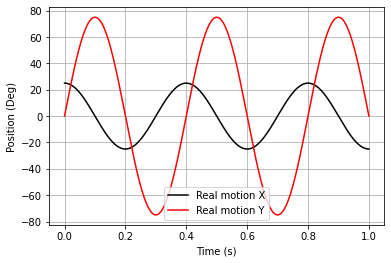

In [172]:
# Let's see what the motion looks like
plt.figure()
plt.plot(t, xr, c = 'k', label = 'Real motion X')
plt.plot(t, yr, c = 'r', label = 'Real motion Y')
plt.xlabel('Time (s)')
plt.ylabel('Position (Deg)')
plt.grid()
plt.legend()
plt.show()

In [173]:
# This is for 1D Beam
gridMax = 100
xx = np.linspace(-gridMax, gridMax, 5 * gridMax + 1, endpoint = True) # 0.04 grid spacing
yy = np.linspace(-gridMax, gridMax, 5 * gridMax + 1, endpoint = True) # 0.04 grid spacing

xg, yg = np.meshgrid(xx, yy)

xyg = [xg, yg]

# Define 1D Gaussian, which is our beam
def gauss2D(coord, m, s):
    return np.exp(-0.5 * ((coord[0] - m[0]) * (coord[0] - m[0]) + (coord[1] - m[1]) * (coord[1] - m[1])) / (s * s))

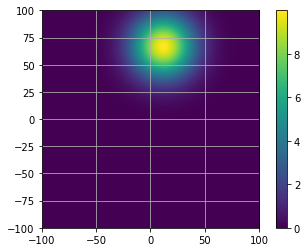

In [174]:
# Test Gaussian
plt.imshow(10 * gauss2D(xyg.copy(), [xr[70000], yr[70000]], 20), origin = 'lower', extent = (-gridMax, gridMax, -gridMax, gridMax))
plt.colorbar()
plt.grid()
plt.show()

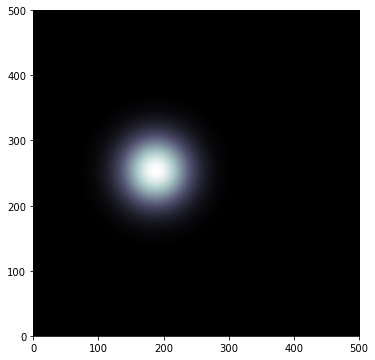

In [175]:
# Animation of the beam
from IPython.display import HTML
from matplotlib import animation
fskip = 1000
fig = plt.figure(figsize = (10, 6))
extent = [0, 5 * gridMax + 1, 0, 5 * gridMax + 1]
im = plt.imshow(np.zeros((5 * gridMax + 1, 5 * gridMax + 1),dtype=float),origin='lower',vmin=0,vmax=1,animated=True,cmap='bone',extent=extent)

def animate(i):
    i *= fskip # every 1000th step (ms)
    im.set_array(gauss2D(xyg, [xr[i], yr[i]], 15))
    return im,

anim = animation.FuncAnimation(fig, animate, frames = xr.shape[0] // fskip, interval = 17, blit = True)
HTML(anim.to_html5_video()) # requires ffmpeg, install using `conda install ffmpeg`

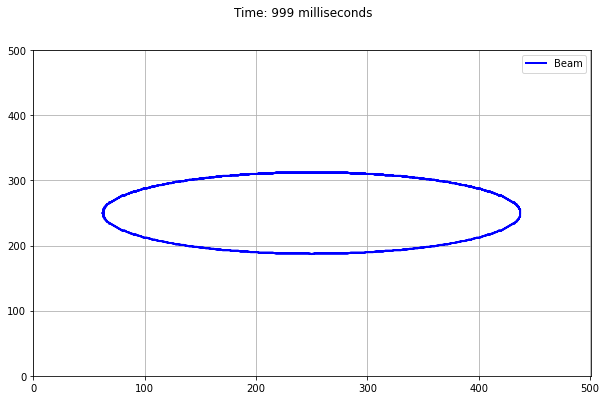

In [29]:
from IPython.display import HTML
from matplotlib import animation

fig = plt.figure(figsize = (10, 6))
ax = plt.axes(xlim=(0, 5 * gridMax + 1), ylim=(0, 5 * gridMax + 1))
fig.suptitle('Time: %d milliseconds' % (0))
plt.grid()
line, = ax.plot([], [], lw=2, c = 'b', label = 'Beam')
fskip = 1000 # one frame per 16 milisecond

lx = []
ly = []

def init():
    line.set_data(lx, ly)
    plt.legend()
    return line, # return a tuple

def animate(fid):
    tid = (fid * fskip) % xr.shape[0] # Time ID: frame ID * frame skip, the modulo keeps it from exceeding array size
    fig.suptitle('Time: %d milliseconds' % (1e3 * t[tid]))
    # y = 10 * gauss1D(xx, xr[tid], 15) # beam at tid, which is index of time (time = tid * Tperiod)
    lx.append((np.abs(xx - xr[tid])).argmin())
    ly.append((np.abs(yy - yr[tid])).argmin())
    line.set_data(lx, ly) # plot X and Y
#     ax.axvline(xr[tid], c = 'r', label = 'Center of beam')
    return line,

anim = animation.FuncAnimation(fig, animate, init_func = init, frames = xr.shape[0] // fskip, interval = 17, blit = True)
HTML(anim.to_html5_video()) # requires ffmpeg, install using `conda install ffmpeg`

In [ ]:
# This is for 2D Beam

# # Now we generate our beam, which is a Gaussian in 2D space around the X coordinate
# gridMax = 100
# xx = np.linspace(-gridMax, gridMax, 5 * gridMax + 1, endpoint = True) # 0.04 grid spacing
# yy = xx # square grid so make an alias
# (xp, yp) = np.meshgrid(xx, yy) # generate X-Y plane

# # Define 2D Gaussian:
# def gauss2D(xx, yy, mx, my, s):
#     xx_ = xx - mx # Recenter X
#     yy_ = yy - my # Recenter Y
#     dist = (xx_*xx_ + yy_*yy_) # calculate Euclidean distance on 2D plane
#     return np.exp(-0.5 * dist / (s * s)) # Gaussian: exp(-x^2/2s^2)

# # Test Gaussian
# plt.figure(figsize=(6,6))
# gaussval = gauss2D(xp, yp, 20, 30, 15) # beam at (20, 30), width 15
# plt.imshow(gaussval, extent = [-gridMax, gridMax, -gridMax, gridMax])
# plt.grid()
# plt.show()
    
# # now to generate the REAL beam position with time, we need to
# # generate a 3D array of the position of these 

# sigr = np.array([gauss2D(xp, yp, mx, 0, 10) for mx in xr]) # beam from source, width 10

## Steepest Descent
Note that, the actual beam is spread in space at every moment in time.
However, at any moment in time we can only sample one point in space (or average of a small area in space).
A-priori information is the peak of the beam at $t = 0$.
At subsequent points in time, as the peak of the beam moves about, we need to find it. 

#### At any point of time, you can ONLY sample one point in space or the average of a small area in space.

In [203]:
# generate the gaussian signal
def generate_sig(step, width):
    return gauss2D(xyg, [xr[step], yr[step]], width)

# measure the signal with a Gaussian uncertainty of 5% (signal strength 1)
def measure_sig(step, posx, posy, width):
    # sig = generate_sig(step, width)[posx, posy]
    # Optimize this:
    _x = (xx[posx] - xr[step]) / width
    _y = (yy[posy] - yr[step]) / width
    sig = np.exp(-0.5*(_x * _x + _y * _y))
#     return sig + (np.random.random()-0.5) * 0.01 # 0.5% uncertainty in signal measurement
    return np.abs(sig + (np.random.random()-0.5) * 0.1) # 5% uncertainty in signal measurement
"""
istep: Time index in the beginning
istop: Time index to end at
width: Beam width
dt   : Number of time steps between two steps of the steepest descent loop
alpha: Gain for the time derivative in the steepest descent
beta : Gain for the space derivative in the steepest descent
"""
def track_max(istep, istop, width, dt, alpha, beta):
    sigtrack_arr = []
    xtrack_arr = []
    print(np.where(generate_sig(istep, width)==generate_sig(istep, width).max()))
    guess_i_x = np.where(generate_sig(istep, width)==generate_sig(istep, width).max())[1][0] # at t = 0, this is where the emitter is
#     guess_i_x = (np.abs(xx - xr[istep])).argmin()
    print(guess_i_x)
    
    guess_i_y = np.where(generate_sig(istep, width)==generate_sig(istep, width).max())[0][0] # at t = 0, this is where the emitter is
#     guess_i_y = (np.abs(yy - yr[istep])).argmin()
    print(guess_i_y)
    
    xtrack_arr.append([guess_i_x, guess_i_y])
    
    msig = measure_sig(istep, guess_i_x, guess_i_y, width) # initial signal measurement
    print("Step: %d, Movement, signal: %.3e %.3e %.3e"%(istep, 0, 0, msig))
    sigtrack_arr.append(msig)
    xtrack_arr.append([guess_i_x, guess_i_y])
    
    msig2 = measure_sig(istep + dt, guess_i_x, guess_i_y, width) # second guess
    print("Step: %d, Movement, signal: %.3e %.3e %.3e"%(istep + dt, 0, 0, msig2))
    sigtrack_arr.append(msig2)
    tderivative = (msig2 - msig) * FreqHz / dt # partial time derivative of signal
    xderivative = 0
    yderivative = 0
#     alpha = (1/Nsamp) * 200 # learning rate for time (0.5% uncertainty)
#     beta = 400 # learning rate for space(0.5% uncertainty)
    # alpha = (dt/Nsamp) * 50 # learning rate for time
    alpha *= dt/Nsamp # setting the unit
    # beta = 50 # learning rate for space
    istop = istop if istop < Nsamp else Nsamp
    atX = True
    for i in range(istep + 2 * dt, istop, dt): # steps in T
        msig = msig2 # save the old measurement
        dx = 0
        dy = 0
        if not atX: # odd case, Y
            guess_i_x2 = guess_i_x
            dy = alpha * tderivative - beta[1] * yderivative
            yguess_i = int(guess_i_y - dy) # new guess     
            if (yguess_i >= 0 and yguess_i < yy.shape[0]): # not OOB
                guess_i_y2 = yguess_i # update the guess
            else:
                guess_i_y2 = guess_i_y # keep the old guess
        else: # even case, X
            guess_i_y2 = guess_i_y
            dx = alpha * tderivative - beta[0] * xderivative
            xguess_i = int(guess_i_x - dx) # new guess
            if (xguess_i >= 0 and xguess_i < xx.shape[0]): # not OOB
                guess_i_x2 = xguess_i # update the guess
            else:
                guess_i_x2 = guess_i_x # keep the old guess        
            
        msig2 = measure_sig(i, guess_i_x2, guess_i_y2, width) # new measurement at new/old position
        if not (i % 1000):
            print("Step: %d, Movement, signal: %.3e %.3e %.3e"%(i, dx, dy, msig2))
        
        tderivative = (msig2 - msig) * FreqHz / dt # partial time derivative of signal
        
        if not atX: # odd case, Y
            if (guess_i_y2 == guess_i_y): # if we did not change position
                yderivative = 0 # x partial derivative is zero
            else:
                yderivative = (msig2 - msig) / (guess_i_y2 - guess_i_y) # partial spatial derivative of signal
        else:
            if (guess_i_x2 == guess_i_x): # if we did not change position
                xderivative = 0 # x partial derivative is zero
            else:
                xderivative = (msig2 - msig) / (guess_i_x2 - guess_i_x) # partial spatial derivative of signal
            
            
        sigtrack_arr.append(msig) # append new signal
        
        xtrack_arr.append([guess_i_x2, guess_i_y2]) # append new position
        
        guess_i_x = guess_i_x2 # update old position with new
        
        guess_i_y = guess_i_y2 # update old position with new
        
        atX = not atX
        
    return (np.array(xtrack_arr, dtype = int), np.array(sigtrack_arr, dtype = float))
    

In [214]:
# Track from t = 0, beam width 15, perform measurement at every timestep (not ideal), learning rates alpha, beta = 50
istart = 0
istop = 400000
istep = 1
bwidth = 15
# alpha and beta parameters are found with trial and error
xtrack_arr, sigtrack_arr = track_max(istart, istop, bwidth, istep, 10, [65, 65])

(array([250, 250]), array([312, 313]))
312
250
Step: 0, Movement, signal: 0.000e+00 0.000e+00 1.013e+00
Step: 1, Movement, signal: 0.000e+00 0.000e+00 9.754e-01
Step: 1000, Movement, signal: -3.375e+00 0.000e+00 9.794e-01
Step: 2000, Movement, signal: 1.500e+00 0.000e+00 9.561e-01
Step: 3000, Movement, signal: -4.250e+00 0.000e+00 9.810e-01
Step: 4000, Movement, signal: -6.015e-01 0.000e+00 9.148e-01
Step: 5000, Movement, signal: -5.427e-02 0.000e+00 8.459e-01
Step: 6000, Movement, signal: -1.160e-01 0.000e+00 1.032e+00
Step: 7000, Movement, signal: -3.421e+00 0.000e+00 8.401e-01
Step: 8000, Movement, signal: -7.038e-01 0.000e+00 9.494e-01
Step: 9000, Movement, signal: -1.878e+00 0.000e+00 7.429e-01
Step: 10000, Movement, signal: -7.554e-01 0.000e+00 9.608e-01
Step: 11000, Movement, signal: -2.096e-01 0.000e+00 9.412e-01
Step: 12000, Movement, signal: -3.675e+00 0.000e+00 9.870e-01
Step: 13000, Movement, signal: -2.248e+00 0.000e+00 9.520e-01
Step: 14000, Movement, signal: 1.056e+00 0.

Step: 139000, Movement, signal: 2.481e+00 0.000e+00 9.041e-01
Step: 140000, Movement, signal: -2.552e-01 0.000e+00 9.360e-01
Step: 141000, Movement, signal: -1.656e+00 0.000e+00 9.291e-01
Step: 142000, Movement, signal: 9.155e-01 0.000e+00 8.452e-01
Step: 143000, Movement, signal: 4.620e-01 0.000e+00 9.503e-01
Step: 144000, Movement, signal: -1.763e+00 0.000e+00 9.384e-01
Step: 145000, Movement, signal: -1.483e+00 0.000e+00 9.587e-01
Step: 146000, Movement, signal: -6.261e-02 0.000e+00 7.960e-01
Step: 147000, Movement, signal: -4.739e-01 0.000e+00 9.658e-01
Step: 148000, Movement, signal: -1.927e-01 0.000e+00 9.084e-01
Step: 149000, Movement, signal: -1.343e+00 0.000e+00 9.943e-01
Step: 150000, Movement, signal: -7.288e-01 0.000e+00 9.933e-01
Step: 151000, Movement, signal: 7.131e-01 0.000e+00 8.781e-01
Step: 152000, Movement, signal: 5.265e-02 0.000e+00 8.551e-01
Step: 153000, Movement, signal: -2.348e+00 0.000e+00 9.122e-01
Step: 154000, Movement, signal: 4.581e-01 0.000e+00 9.085e-0

Step: 287000, Movement, signal: -2.061e+00 0.000e+00 9.615e-01
Step: 288000, Movement, signal: -1.364e+00 0.000e+00 9.646e-01
Step: 289000, Movement, signal: -4.151e-01 0.000e+00 9.897e-01
Step: 290000, Movement, signal: 4.249e-01 0.000e+00 9.801e-01
Step: 291000, Movement, signal: 1.095e+00 0.000e+00 1.019e+00
Step: 292000, Movement, signal: 2.490e+00 0.000e+00 7.970e-01
Step: 293000, Movement, signal: -2.390e-01 0.000e+00 9.769e-01
Step: 294000, Movement, signal: 7.932e-01 0.000e+00 8.716e-01
Step: 295000, Movement, signal: -1.822e+00 0.000e+00 9.819e-01
Step: 296000, Movement, signal: 1.805e+00 0.000e+00 9.910e-01
Step: 297000, Movement, signal: -1.286e+00 0.000e+00 9.976e-01
Step: 298000, Movement, signal: -2.676e+00 0.000e+00 8.574e-01
Step: 299000, Movement, signal: -3.767e+00 0.000e+00 9.801e-01
Step: 300000, Movement, signal: 8.002e-01 0.000e+00 9.223e-01
Step: 301000, Movement, signal: 1.782e-01 0.000e+00 1.017e+00
Step: 302000, Movement, signal: -4.814e-01 0.000e+00 8.444e-01

In [216]:
src_track = []
for i in range(0, istop, 100): # for each position of the beam
    guess_i_x = np.where(generate_sig(i, 15)==generate_sig(i, 15).max())[1][0] # at t = 0, this is where the emitter is
    guess_i_y = np.where(generate_sig(i, 15)==generate_sig(i, 15).max())[0][0] # at t = 0, this is where the emitter is
#     src_track.append([(np.abs(xx - xr[i])).argmin(), (np.abs(yy - yr[i])).argmin()])
    src_track.append([guess_i_x, guess_i_y])
src_track = np.array(src_track, dtype = float)
src_track.shape

(4000, 2)

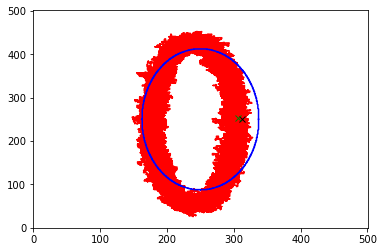

In [215]:
plt.plot(xtrack_arr[:,0], xtrack_arr[:,1], c='r')
plt.plot(src_track[:, 0], src_track[:, 1], c='b')
plt.plot(xtrack_arr[0,0], xtrack_arr[0,1], marker='x',c='k')
plt.plot(xtrack_arr[100,0], xtrack_arr[100,1], marker='x',c='g')
plt.xlim(0, 5 * gridMax + 1)
plt.ylim(0, 5 * gridMax + 1)
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize = (18, 12))

color = 'k'
ax1.set_ylabel('Tracking Error', color=color)  # we already handled the x-label with ax1
poserr = src_xtrack - xtrack_arr
plt.plot(t[istart::istep], poserr, color = 'c', label = "Beam position error")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-gridMax, gridMax)
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Beam Positions', color=color)
plt.plot(t[istart::istep], xtrack_arr, color = 'b', label = "Tracked beam maximum position")
plt.plot(t[istart::istep], src_xtrack, color = 'r', label = "Real beam maximum position")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
srcpos_f = np.fft.fftshift(np.fft.fft(src_xtrack))
mespos_f = np.fft.fftshift(np.fft.fft(xtrack_arr))
k_ax = np.fft.fftshift(np.fft.fftfreq(srcpos_f.shape[0]))
plt.figure(figsize = (18, 12))
plt.plot(k_ax, np.arctan2(srcpos_f.imag, srcpos_f.real), label = "Source position FFT Phase", color = 'r', marker = 'o', ls = '')
plt.plot(k_ax, np.arctan2(mespos_f.imag, mespos_f.real), label = "Measured position FFT Phase", color = 'b', marker = 'x')
plt.grid()
plt.legend()
plt.xlim(0, 100/100000)



In [ ]:
plt.figure(figsize = (18, 12))
plt.plot(k_ax, np.arctan2(srcpos_f.imag, srcpos_f.real) - np.arctan2(mespos_f.imag, mespos_f.real), label = "FFT Phase Difference", color = 'r', marker = 'x')
plt.axhline(0)
plt.grid()
plt.legend()
plt.xlim(0, 30/100000)

In [ ]:
fig, ax1 = plt.subplots(figsize = (18, 12))

color = 'k'
ax1.set_ylabel('Tracking Error', color=color)  # we already handled the x-label with ax1
poserr = src_xtrack - xtrack_arr
plt.plot(t[istart::istep], poserr, color = 'c', label = "Beam position error")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-gridMax, gridMax)
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Beam Positions', color=color)
plt.plot(t[istart::istep], xtrack_arr, color = 'b', label = "Tracked beam maximum position")
plt.plot(t[istart::istep], src_xtrack, color = 'r', label = "Real beam maximum position")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()